## Hackathon 3 : Sentiment Classification

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [38]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from autocorrect import Speller
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV

import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

#### Import DataSet

In [39]:
traindf = pd.read_csv("train.csv")
#testdf = pd.read_csv("test.csv")

In [40]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

## EDA

#### Checking Train DataSet

In [41]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

tweets_text = traindf.tweet.str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

HAPPY_EMO = r" ([xX;:]-?[dD)]|:-?[\)]|[;:][pP]) "
SAD_EMO = r" (:'?[/|\(]) "
print("Happy emoticons:", set(re.findall(HAPPY_EMO, tweets_text)))
print("Sad emoticons:", set(re.findall(SAD_EMO, tweets_text)))

In [42]:
temp = traindf.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

In [43]:
temp

sentiment  tweet
1          1   4310
2          2   2382
0          0    456
3          3    125

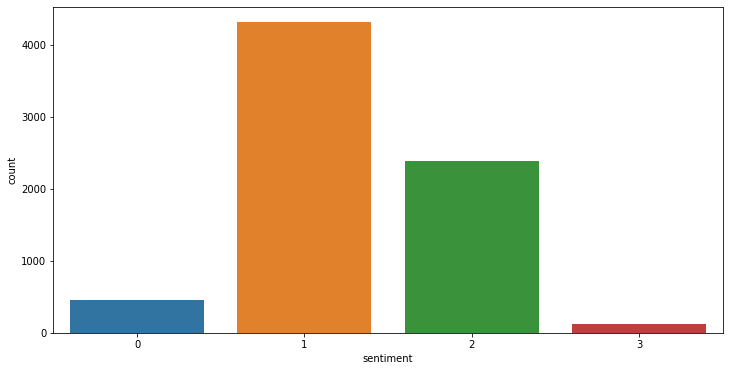

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=traindf)

In [45]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))

fig.show()

In [46]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

In [47]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

In [48]:
traindf.head()


tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [49]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

## Stop Words Removal

stopwords.words('english')


In [50]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning

In [51]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [52]:
convert_emoticons("Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw")

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw Happy face or smiley #SXSW #cbatsxsw'

In [53]:
traindf.tweet[220]

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw'

In [54]:
def dataCleaning(df,stemming = False, lemmatization=False):
    html_parser = HTMLParser()
    
    # convert column type to string
    df['tweet'] = df['tweet'].astype(str)
    
    
    # to lower case
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    #stopword removal  , removed NOT from STOP-WORDS
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    stop_words = all_stopwords
    traindf['tweet'] =  traindf['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #removing @mention
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
    #removing @handles , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
     #removing Http links , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
    #converting emoticon
    df['tweet']= df['tweet'].apply(lambda x: convert_emoticons(x))
    
    # remove numbers
    df['tweet']= df['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

    # remove punctuations and convert characters to lower case
    df['tweet'] = df['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
    #converting Html Encoding
    
    df['tweet']= df['tweet'].apply(lambda x: html_parser.unescape(x))
    
    #removing #HashTags 
    #df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
    # #removing '#' symbol 
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
    #replacing double whitespace with single 
    df['tweet']= df['tweet'].apply(lambda x: re.sub(' +', ' ',x))
    
    #Removing RT
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))
    
    if stemming:
        st = SnowballStemmer('english')
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
                                        
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in x.split()]))
    
#     #Spelling Correction
#     df['tweet']= df['tweet'].apply(lambda x: TextBlob(x).correct() )
      
    
    return df

In [55]:
traindf = dataCleaning(traindf,stemming=False,lemmatization=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [56]:
traindf.tweet[220]

'awwww yeah congrats win last ipad case boyfriend aw happy face or smiley sxsw cbatsxsw'

In [57]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  sxswnui sxsw apple define language touch diffe...          1
1      1851  learn ab google doodle doodle light funny amp ...          1
2      2689  one inyourface ex steal show yrs quotat sxsw a...          2
3      4525  iphone sxsw app would b pretty awesome crash e...          0
4      3604  line outside apple store austin wait new ipad ...          1



#nltk.download('wordnet')
def stem_tokenize(text):
    stemmer = SnowballStemmer("english")
    #stemmer = WordNetLemmatizer()
    return [stemmer.lemmatize(token) for token in word_tokenize(text)]

def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

tfidf = TfidfVectorizer(stop_words="english")

In [58]:
tfidf = TfidfVectorizer()

In [59]:
vector_tfidf = tfidf.fit_transform(traindf["tweet"])



In [60]:
X_tfidf = vector_tfidf.toarray()


In [61]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
print("df",X_tfidf.shape)

df (7274, 8380)


In [63]:
traindf['sentiment']

0       1
1       1
2       2
3       0
4       1
       ..
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7274, dtype: int64

X_train,X_test,y_train,y_test = train_test_split(traindf['tweet'],traindf['sentiment'],test_size=0.4,random_state=42)

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,traindf['sentiment'],test_size=0.4,random_state=42)

nb= MultinomialNB()

nb.fit(X_train, y_train)
y_pred = model.predict(X_test)
#auc = roc_auc_score(y_test, y_pred)
print('Classification Report:')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#print('ROC_AUC_SCORE is',roc_auc_score(y_test, y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))

## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
lr = LogisticRegression()
print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_Logistic.csv', index=False) 
    
print("successfully completed ")

In [64]:
logistic_param = dict(
                    #penalty= ['l1', 'l2','elasticnet'],
    #penalty= ['elasticnet'],
                  C= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
                 # solver=['liblinear', 'saga','sag','lbfgs']
                #  solver=['saga']
                  )

In [65]:
logistic_param

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [66]:
MultiNBparams = dict(alpha= [0.5,1, 1.5],
               fit_prior = [True, False] )

In [67]:
SGDparams = dict(
                  penalty= ['l1', 'l2','elasticnet'] 
                )

In [68]:
DecisionTreeClassifierparams = dict(
                               criterion = ['gini','entropy'],
                               splitter= ['best','random']
                                )

In [69]:
# Number of trees in random forest
n_estimators = [100,150,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
RandomForestClassifierparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [70]:
BernoulliNBparam = {
                    'fit_prior':[True,False]
}

In [71]:
ExtraTreesClassifierParam = {
    'criterion':['gini','entropy']
    
}

In [72]:
ParamsGrid = [ logistic_param ,MultiNBparams,SGDparams,DecisionTreeClassifierparams,RandomForestClassifierparam ,BernoulliNBparam,ExtraTreesClassifierParam  ]

# RESEARCH WORK -- DONT TOUCH"

# Custom Objects

SimplexgbClassifier = XGBClassifier()
SoftMax_Simple_xgbClassifier = XGBClassifier(objective='multi:softmax')
XGBRFClassifier = XGBRFClassifier()

parameters = {'learning_rate': [0.01,0.02],
                  'max_depth'    : [4,6] 
                 }

In [73]:
def run_model(predictors,target,test_df, model,model_name,params):
    print("inside "+model_name)
    predictors.shape
    target.shape
    print(":::")
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)
    
    #grid
    grid = GridSearchCV(estimator=model,param_grid = params, cv = 5, n_jobs=2, verbose=9)
    
    grid.fit(x_train, y_train)
    y_pred = grid.predict(x_test)
    
    print('=========BEST FEATURES========')
    print(grid.best_params_) 
    
    
    print('=========BEST Estimator========')
    print(grid.best_estimator_)
    
    print('=========Classification Report=========:')
    print(classification_report(y_test,y_pred))
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))
    
#     #For TEST DataSet
#     if 'test_df' in locals():
#         del test_df
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
#     if 'testdf' in globals():
#         del testdf
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
   # testdf = pd.read_csv("test.csv")
   # testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
    print("testdf, ",test_df.shape)
    
    test_id_col = test_df['tweet_id']
    print("test_id_col ",test_id_col.shape)
    
    print("Dropping Id column")
    test_df_drop_id = test_df.drop(['tweet_id'],axis=1)
    print("test_df_drop_id ",test_df_drop_id.shape)
    
    #Transform Test DataSet using TFiDF
    testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])
    
    #Predicting TestValues
    print('Predicting TestValues')
    predict = grid.predict(testdf_tfidf)
  
    print(predict.shape)
    print(test_df_drop_id.shape)

    print('Adding Test prediction to Column')
    #Adding Test prediction to Column
    test_df_drop_id['sentiment']= grid.predict(testdf_tfidf)
    
    print('Concat both column to Pandas')
    #Concat both column to Pandas
    submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
    print('Creating CSV')
    #Creating CSV
    submissions_nb.to_csv('submissions_'+model_name+'.csv', index=False) 
    
    print("successfully completed "+model_name)

In [74]:
# Predictors
X = X_tfidf

# Target
y = traindf['sentiment']

#TestDF
testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=False,lemmatization=True)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}
models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
         'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier  }
    
p=0;
for i in models.items():
    # run model
    
    model = i[1]()
    model_name = i[0]
    print("X_Tfidf: ",X_tfidf.shape)
    print("senti shape: ",traindf['sentiment'].shape)
    run_model(X_tfidf, traindf['sentiment'],testdf, model,model_name,params= ParamsGrid[p]) # train and returns AUC test score
    p=p+1;
    print('===='*20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



X_Tfidf:  (7274, 8380)
senti shape:  (7274,)
inside Logistic Regression
:::
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   29.4s
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:   37.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



=========BEST FEATURES========
{'C': 10}
=========BEST Estimator========
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.49      0.21      0.30       121
           1       0.70      0.82      0.75      1304
           2       0.58      0.48      0.52       719
           3       0.25      0.03      0.05        39

    accuracy                           0.66      2183
   macro avg       0.50      0.38      0.41      2183
weighted avg       0.64      0.66      0.64      2183

F1 weighted score: 0.640415191920306
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Pred

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   31.7s finished


=========BEST FEATURES========
{'alpha': 1.5, 'fit_prior': False}
=========BEST Estimator========
MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.33      0.07      0.12       121
           1       0.68      0.82      0.74      1304
           2       0.53      0.42      0.47       719
           3       0.00      0.00      0.00        39

    accuracy                           0.63      2183
   macro avg       0.39      0.33      0.33      2183
weighted avg       0.60      0.63      0.61      2183

F1 weighted score: 0.6061502892815223
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Multinomial NaiveBais
X_Tfidf:  (7274, 8380)
senti shape:  (7274,)
inside Linear SVM
:::
Fitting 5 folds

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  8.5min finished


=========BEST FEATURES========
{'penalty': 'l1'}
=========BEST Estimator========
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.52      0.18      0.27       121
           1       0.68      0.87      0.76      1304
           2       0.60      0.39      0.47       719
           3       0.00      0.00      0.00        39

    accuracy                           0.66      2183
   macro avg       0.45      0.36      0.38      2183
weighted avg       0.63      0.66      0.63      2183

F1 weighted score: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



X_Tfidf:  (7274, 8380)
senti shape:  (7274,)
inside Decision Tree
:::
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   41.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.9min finished


=========BEST FEATURES========
{'criterion': 'gini', 'splitter': 'random'}
=========BEST Estimator========
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.37      0.30      0.33       121
           1       0.69      0.78      0.73      1304
           2       0.54      0.45      0.49       719
           3       0.09      0.05      0.06        39

    accuracy                           0.63      2183
   macro avg       0.42      0.39      0.40      2183
weighted avg       0.61      0.63      0.62      2183

F1 weighte

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   38.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 15.1min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 21.0min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 27.3min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 34.7min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 43.1min
[Parallel(n_jobs=2)]: Done 238 tasks      | elapsed: 52.1min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 62.7min
[Parallel(n_jobs=2)]: Done 334 tasks      | elapsed: 79.2min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 97.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 117.3min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 138.8min
[Paralle

=========BEST FEATURES========
{'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
=========BEST Estimator========
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.62      0.99      0.76      1304
           2       0.85      0.09      0.17       719
           3       0.00      0.00      0.00        39

    accuracy             

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed RandomForestClassifier
X_Tfidf:  (7274, 8380)
senti shape:  (7274,)
inside BernoulliNB
:::
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.1s finished


=========BEST FEATURES========
{'fit_prior': False}
=========BEST Estimator========
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.70      0.81      0.75      1304
           2       0.53      0.49      0.51       719
           3       0.00      0.00      0.00        39

    accuracy                           0.64      2183
   macro avg       0.31      0.32      0.31      2183
weighted avg       0.59      0.64      0.61      2183

F1 weighted score: 0.6139091001598711
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed BernoulliNB

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.




X_Tfidf:  (7274, 8380)
senti shape:  (7274,)
inside ExtraTreesClassifier
:::
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   51.0s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



=========BEST FEATURES========
{'criterion': 'gini'}
=========BEST Estimator========
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
=========Classification Report=========:
              precision    recall  f1-score   support

           0       0.46      0.18      0.26       121
           1       0.68      0.88      0.77      1304
           2       0.65      0.40      0.50       719
           3       0.14      0.03      0.04        39

    accuracy                           0.67      2183
   macro avg       0.48      0.37      0.39      2183
weighted avg     

## Other Appproach

count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)

nb= MultinomialNB() 

X_train_tfidf.shape

nb.fit(X_train_tfidf, y_train)

X_test_tf = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_tf)

predicted = nb.predict(X_test_tfidf)

predicted.shape

accuracy_score(y_test,predicted)

## TEST

testdf = pd.read_csv("test.csv")

testdf = dataCleaning(testdf)

testdf.head()

testdf.shape

test_id_col = testdf['tweet_id']

test_id_col.shape

test_df_drop_id = testdf.drop(['tweet_id'],axis=1)

test_df_drop_id.shape

test_df_drop_id['tweet']

test_df_drop_id['tweet']

testdf_tf = count_vect.transform(test_df_drop_id['tweet'])

testdf_tfidf = tfidf_transformer.transform(testdf_tf)

testdf_tfidf.shape

predict = nb.predict(testdf_tfidf)

predict

predict.shape

test_df_drop_id['sentiment']= nb.predict(testdf_tfidf)

submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 

submissions_nb.to_csv('submissions_NB.csv', index=False) 

# XGBClassifier

In [ ]:
## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
#lr = XGBClassifier() 
lr = XGBClassifier(objective='multi:softmax')

print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_SoftMax_Simple_xgbClassifier.csv', index=False) 
    
print("successfully completed ")

:::
